# Libraries

In [16]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Input,Conv2D,Conv2DTranspose,Reshape,Dense,Flatten,Layer
from keras.engine.training import Model
import matplotlib.pyplot as plt

# Load Dataset

In [3]:
(x_train,_),(x_test,_)=tf.keras.datasets.mnist.load_data()
data = np.concatenate([x_train,x_test],axis=0)
data = np.expand_dims(data,-1).astype('float32')/255

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
data = tf.data.Dataset.from_tensor_slices(data)

# TF Pipeline

In [115]:
train_data  = data.shuffle(buffer_size=1024,reshuffle_each_iteration=True).batch(128).prefetch(tf.data.AUTOTUNE)

In [116]:
Latent_dim=2
Batch_size=128

In [174]:
class Sampling(Layer):
  def call(self,inputs):
    mean,log_var=inputs
    return mean+tf.math.exp(0.5*log_var)*tf.random.normal(shape=(128,2))

# Encoder

In [175]:
encoder_inputs = Input(shape=(28,28,1))
x=Conv2D(32,3,activation='relu',padding='same',strides=2)(encoder_inputs)
x=Conv2D(64,3,activation='relu',padding='same',strides=2)(x)
x=Flatten()(x)

x = Dense(16,activation='relu')(x)

mean = Dense(Latent_dim,)(x)
log_var = Dense(Latent_dim,)(x)

z= Sampling()([mean,log_var])

encoder = Model(encoder_inputs,[z,mean,log_var],name='encoder')
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_44 (InputLayer)          [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_42 (Conv2D)             (None, 14, 14, 32)   320         ['input_44[0][0]']               
                                                                                                  
 conv2d_43 (Conv2D)             (None, 7, 7, 64)     18496       ['conv2d_42[0][0]']              
                                                                                                  
 flatten_21 (Flatten)           (None, 3136)         0           ['conv2d_43[0][0]']              
                                                                                            

# Decoder

In [176]:
latent_inputs = Input(shape=(Latent_dim,))
x= Dense(7*7*64,activation='relu')(latent_inputs)
x= Reshape((7,7,64))(x)

x= Conv2DTranspose(64,3,strides=2,activation='relu',padding='same')(x)
x= Conv2DTranspose(64,3,strides=2,activation='relu',padding='same')(x)
output= Conv2DTranspose(1,3,activation='sigmoid',padding='same')(x)

decoder = Model(latent_inputs,output,name='decoder')

decoder.summary()


Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_45 (InputLayer)       [(None, 2)]               0         
                                                                 
 dense_74 (Dense)            (None, 3136)              9408      
                                                                 
 reshape_8 (Reshape)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_transpose_24 (Conv2D  (None, 14, 14, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_25 (Conv2D  (None, 28, 28, 64)       36928     
 Transpose)                                                      
                                                                 
 conv2d_transpose_26 (Conv2D  (None, 28, 28, 1)        577 

In [177]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
epoch=20

# Calculate Loss

In [178]:
def calculate_loss(y_true,y_pred,mean,log_var):
  reconstruction_loss = tf.reduce_mean(tf.reduce_sum(tf.keras.losses.binary_crossentropy(y_true,y_pred),axis=(1,2)))
  regularization_loss = tf.reduce_mean(tf.reduce_sum(-0.5*(log_var+1-tf.math.square(mean)-tf.math.exp(log_var)),axis=1))
  return reconstruction_loss+regularization_loss

# Training

In [179]:
def training(x_batch):
  with tf.GradientTape() as tape:
    z,mean,log_var = encoder(x_batch)
    y_pred = decoder(z)
    y_true = x_batch
    loss = calculate_loss(y_true,y_pred,mean,log_var)
  partial_derivate = tape.gradient(loss,vae.trainable_weights)
  optimizer.apply_gradients(zip(partial_derivate,vae.trainable_weights))
  return loss

# VAE

In [180]:
vae_input = Input(shape=(28,28,1))
z,_,_ = encoder(vae_input)
output=decoder(z)
vae = Model(vae_input,output,name='vae')
vae.summary()

Model: "vae"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_46 (InputLayer)       [(None, 28, 28, 1)]       0         
                                                                 
 encoder (Functional)        [(128, 2),                69076     
                              (None, 2),                         
                              (None, 2)]                         
                                                                 
 decoder (Functional)        (None, 28, 28, 1)         83841     
                                                                 
Total params: 152,917
Trainable params: 152,917
Non-trainable params: 0
_________________________________________________________________


# Run Model

In [181]:
def run(epochs):
  for epoch in range(1,epochs+1):
    print(f'Epoch={epoch}')

    for step,x_batch in enumerate(train_data.take(100)):
      loss=training(x_batch)
    print(f'Training Loss={loss}')

In [182]:
run(epoch)

Epoch=1
Training Loss=210.67579650878906
Epoch=2
Training Loss=208.8356475830078
Epoch=3
Training Loss=208.49327087402344
Epoch=4
Training Loss=186.6053466796875
Epoch=5
Training Loss=182.1016845703125
Epoch=6
Training Loss=170.9310760498047
Epoch=7
Training Loss=179.13330078125
Epoch=8
Training Loss=170.9808807373047
Epoch=9
Training Loss=174.7168426513672
Epoch=10
Training Loss=171.49110412597656
Epoch=11
Training Loss=173.5630340576172
Epoch=12
Training Loss=164.29876708984375
Epoch=13
Training Loss=170.7241973876953
Epoch=14
Training Loss=162.2822723388672
Epoch=15
Training Loss=167.61305236816406
Epoch=16
Training Loss=167.7314910888672
Epoch=17
Training Loss=165.37353515625
Epoch=18
Training Loss=160.69448852539062
Epoch=19
Training Loss=159.0235595703125
Epoch=20
Training Loss=155.18597412109375


In [193]:
lst = [[-0.5,0],[-1,1],[-0.5,0.43],[0,1],[-1,-0.9],[-0.7,1],[-1,-0.8],[-0.7,0.6],[0.4,-0.3]]

# Evaluation

1/1 [==============================] - 0s 23ms/step


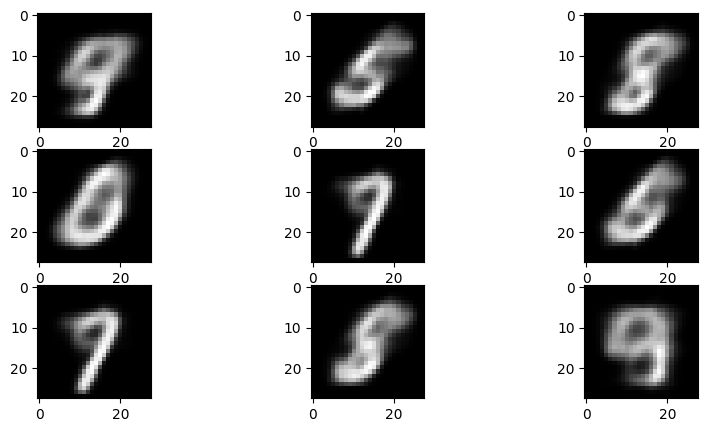

In [194]:
plt.figure(figsize=(10,5))
for i in range(len(lst)):
  plt.subplot(3,3,i+1)
  plt.imshow(vae.layers[2].predict(tf.constant([lst[i]]))[0][...,0],cmap='gray')